<a href="https://colab.research.google.com/github/DestonSJU/GenAI/blob/main/Problem1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

//*** Deston Willis

//*** Generative AI

//*** 10/11/24

//*** Homework 3: The purpose of this assignment is to create a Variational Autoencoder, train it, and compare the images that it reconstructs with original ones from the dataset

1. First, I made made some inital imports and I loaded the dataset. I then normalized and resized the data. I also displayed the shape of the training and test data.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import (
    layers,
    models,
    datasets,
    callbacks,
    losses,
    optimizers,
    metrics,
)

from scipy.stats import norm


In [2]:
IMAGE_SIZE = 32
BATCH_SIZE = 100
VALIDATION_SPLIT = 0.2
EMBEDDING_DIM = 2
EPOCHS = 5
BETA = 500

In [3]:
!wget http://ufldl.stanford.edu/housenumbers/train_32x32.mat
!wget http://ufldl.stanford.edu/housenumbers/test_32x32.mat

--2024-10-12 01:07:26--  http://ufldl.stanford.edu/housenumbers/train_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182040794 (174M) [text/plain]
Saving to: ‘train_32x32.mat’

train_32x32.mat     100%[===================>] 173.61M  6.15MB/s    in 24s     

2024-10-12 01:07:51 (7.19 MB/s) - ‘train_32x32.mat’ saved [182040794/182040794]

--2024-10-12 01:07:51--  http://ufldl.stanford.edu/housenumbers/test_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64275384 (61M) [text/plain]
Saving to: ‘test_32x32.mat’

test_32x32.mat      100%[===================>]  61.30M  4.66MB/s    in 14s     

2024-10-12 01:08:05 (4.34 MB/s) - ‘test_32x32.mat’ saved [64275384/64

In [4]:
from scipy.io import loadmat

# Load data
train_data = loadmat('train_32x32.mat')
test_data = loadmat('test_32x32.mat')

# Preprocess the data
x_train = np.transpose(train_data['X'], (3, 0, 1, 2)).astype('float32') / 255.0
y_train = train_data['y'].flatten()
x_test = np.transpose(test_data['X'], (3, 0, 1, 2)).astype('float32') / 255.0
y_test = test_data['y'].flatten()

# Display the shape of the datasets
print(f'Training data shape: {x_train.shape}')
print(f'Test data shape: {x_test.shape}')

Training data shape: (73257, 32, 32, 3)
Test data shape: (26032, 32, 32, 3)


2. To set up the VAE, firts I set up a sampling class, followed by the arcitecture for the encoder and the decoder. I also create two functions to update the encoder and decoder respectfully so that specified latent dimensions can be used. Next I have the VAE class which has functions for creating and training the VAE. Finally, I have the build_VAE function which takes a specificed latent dimension and calls the encoder and decoder update functions to update their latent space values before calling the VAE class to create a VAE.

In [20]:
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [21]:
# Encoder
encoder_input = layers.Input(
    shape=(IMAGE_SIZE, IMAGE_SIZE, 3), name="encoder_input"
)
x = layers.Conv2D(32, (3, 3), strides=2, activation="relu", padding="same")(
    encoder_input
)
x = layers.Conv2D(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(128, (3, 3), strides=2, activation="relu", padding="same")(x)
shape_before_flattening = K.int_shape(x)[1:]  # the decoder will need this!

x = layers.Flatten()(x)
z_mean = layers.Dense(EMBEDDING_DIM, name="z_mean")(x)
z_log_var = layers.Dense(EMBEDDING_DIM, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

encoder = models.Model(encoder_input, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 16, 16, 32)           896       ['encoder_input[0][0]']       
                                                                                                  
 conv2d_1 (Conv2D)           (None, 8, 8, 64)             18496     ['conv2d[0][0]']              
                                                                                                  
 conv2d_2 (Conv2D)           (None, 4, 4, 128)            73856     ['conv2d_1[0][0]']            
                                                                                            

In [22]:
# Decoder

decoder_input = layers.Input(shape=(EMBEDDING_DIM,), name="decoder_input")
x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x = layers.Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(
    128, (3, 3), strides=2, activation="relu", padding="same"
)(x)
x = layers.Conv2DTranspose(
    64, (3, 3), strides=2, activation="relu", padding="same"
)(x)
x = layers.Conv2DTranspose(
    32, (3, 3), strides=2, activation="relu", padding="same"
)(x)
decoder_output = layers.Conv2D(
    3,
    (3, 3),
    strides=1,
    activation="sigmoid",
    padding="same",
    name="decoder_output",
)(x)

decoder = models.Model(decoder_input, decoder_output)
decoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 2048)              6144      
                                                                 
 reshape (Reshape)           (None, 4, 4, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 8, 8, 128)         147584    
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 16, 16, 64)        73792     
 Transpose)                                                      
                                                                 
 conv2d_transpose_2 (Conv2D  (None, 32, 32, 32)        18464 

In [23]:
#This function takes in an encoder and latent dimension as parameters and replaces the encoder with
#an encoder with the specified laten dimension
def update_encoder(encoder, latent_dim):
  EMBEDDING_DIM = latent_dim
  encoder_input = layers.Input(
      shape=(IMAGE_SIZE, IMAGE_SIZE, 3), name="encoder_input"
  )
  x = layers.Conv2D(32, (3, 3), strides=2, activation="relu", padding="same")(
      encoder_input
  )
  x = layers.Conv2D(64, (3, 3), strides=2, activation="relu", padding="same")(x)
  x = layers.Conv2D(128, (3, 3), strides=2, activation="relu", padding="same")(x)
  shape_before_flattening = K.int_shape(x)[1:]  # the decoder will need this!

  x = layers.Flatten()(x)
  z_mean = layers.Dense(EMBEDDING_DIM, name="z_mean")(x)
  z_log_var = layers.Dense(EMBEDDING_DIM, name="z_log_var")(x)
  z = Sampling()([z_mean, z_log_var])

  temp_encoder = models.Model(encoder_input, [z_mean, z_log_var, z], name="encoder")
  encoder = temp_encoder
  encoder.summary()

In [24]:
#This function takes in a decoder and latent dimension as parameters and replaces the encoder with
#a decoder with the specified laten dimension
def update_decoder(decoder, latent_dim):
  EMBEDDING_DIM = latent_dim
  decoder_input = layers.Input(shape=(EMBEDDING_DIM,), name="decoder_input")
  x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
  x = layers.Reshape(shape_before_flattening)(x)
  x = layers.Conv2DTranspose(
      128, (3, 3), strides=2, activation="relu", padding="same"
  )(x)
  x = layers.Conv2DTranspose(
      64, (3, 3), strides=2, activation="relu", padding="same"
  )(x)
  x = layers.Conv2DTranspose(
      32, (3, 3), strides=2, activation="relu", padding="same"
  )(x)
  decoder_output = layers.Conv2D(
      3,
      (3, 3),
      strides=1,
      activation="sigmoid",
      padding="same",
      name="decoder_output",
  )(x)

  temp_decoder = models.Model(decoder_input, decoder_output)
  decoder = temp_decoder
  decoder.summary()

In [25]:
#This class creates a VAE and contains various functions for training it
class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def call(self, inputs):
        """Call the model on a particular input."""
        z_mean, z_log_var, z = encoder(inputs)
        reconstruction = decoder(z)
        return z_mean, z_log_var, reconstruction

    def train_step(self, data):
        """Step run during training."""
        with tf.GradientTape() as tape:
            z_mean, z_log_var, reconstruction = self(data)
            reconstruction_loss = tf.reduce_mean(
                BETA
                * losses.binary_crossentropy(
                    data, reconstruction, axis=(1, 2, 3)
                )
            )
            kl_loss = tf.reduce_mean(
                tf.reduce_sum(
                    -0.5
                    * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                    axis=1,
                )
            )
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        """Step run during validation."""
        if isinstance(data, tuple):
            data = data[0]

        z_mean, z_log_var, reconstruction = self(data)
        reconstruction_loss = tf.reduce_mean(
            BETA
            * losses.binary_crossentropy(data, reconstruction, axis=(1, 2, 3))
        )
        kl_loss = tf.reduce_mean(
            tf.reduce_sum(
                -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                axis=1,
            )
        )
        total_loss = reconstruction_loss + kl_loss

        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

In [26]:
#This function takes a latent dimension as a parameter and returns a VAE by calling the update_encoder and
#update_decoder functions as well as the VAE class
def build_vae(latent_dim):

  update_encoder(encoder, latent_dim)
  update_decoder(decoder, latent_dim)

  return VAE(encoder, decoder)


3. Before I began training, I set up checkpoints to save the model and early stopping to stop the training if the VAE isn't improving. Then I began training with 50 epochs and batch size of 64. The loss didn't improve much throughout testing. Between the different latent dimensions, 10 had the best total loss with 320.5453 and the best validation loss with 315.42743. All 3 were very close with their loss values.

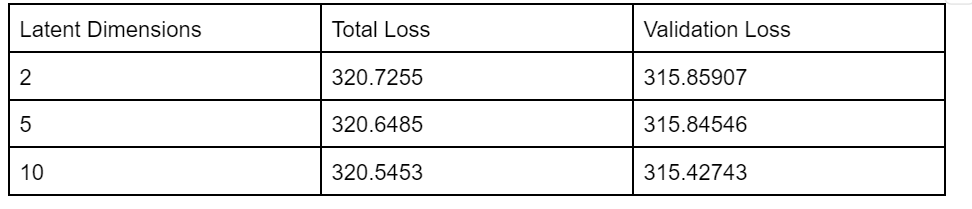

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint_callback = ModelCheckpoint(
    'vae_model.tf',  # Path where the model will be saved
    save_best_only=True,  # Save only the best model
    monitor='val_loss',  # Monitor validation loss
    mode='min',  # We want the minimum loss
    verbose=1  # Print messages when saving
)

early_stopping_callback = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=10,  # Stop training after 10 epochs with no improvement
    verbose=1  # Print messages when stopping
)

In [ ]:
#Train model with 50 epochs and batch size of 64
latent_dims = [2, 5, 10]
for dim in latent_dims:
    print(f'Training VAE with latent dimension: {dim}')
    vae = build_vae(latent_dim=dim)
    vae.compile(optimizer='adam', loss=losses.binary_crossentropy)
    vae.fit(x_train, epochs=50, batch_size=64, validation_data=(x_test, x_test), callbacks=[checkpoint_callback, early_stopping_callback])

Training VAE with latent dimension: 2
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d_6 (Conv2D)           (None, 16, 16, 32)           896       ['encoder_input[0][0]']       
                                                                                                  
 conv2d_7 (Conv2D)           (None, 8, 8, 64)             18496     ['conv2d_6[0][0]']            
                                                                                                  
 conv2d_8 (Conv2D)           (None, 4, 4, 128)            73856     ['conv2d_7[0][0]']            
                                                      

1145/1145 [==============================] - 43s 36ms/step - total_loss: 321.1554 - reconstruction_loss: 318.3645 - kl_loss: 2.7908 - val_loss: 316.8425 - val_reconstruction_loss: 313.6581 - val_kl_loss: 3.1844
Epoch 2/50
1145/1145 [==============================] - ETA: 0s - total_loss: 320.9906 - reconstruction_loss: 318.1736 - kl_loss: 2.8171
Epoch 2: val_loss improved from 316.84253 to 315.99084, saving model to vae_model.tf


1145/1145 [==============================] - 39s 34ms/step - total_loss: 320.9906 - reconstruction_loss: 318.1736 - kl_loss: 2.8171 - val_loss: 315.9908 - val_reconstruction_loss: 313.1039 - val_kl_loss: 2.8870
Epoch 3/50
1143/1145 [============================>.] - ETA: 0s - total_loss: 320.9549 - reconstruction_loss: 318.1293 - kl_loss: 2.8256
Epoch 3: val_loss did not improve from 315.99084
1145/1145 [==============================] - 39s 34ms/step - total_loss: 320.9592 - reconstruction_loss: 318.1337 - kl_loss: 2.8257 - val_loss: 316.0668 - val_reconstruction_loss: 313.1225 - val_kl_loss: 2.9443
Epoch 4/50
1144/1145 [============================>.] - ETA: 0s - total_loss: 320.9196 - reconstruction_loss: 318.0903 - kl_loss: 2.8296
Epoch 4: val_loss improved from 315.99084 to 315.85907, saving model to vae_model.tf


1145/1145 [==============================] - 40s 35ms/step - total_loss: 320.9262 - reconstruction_loss: 318.0967 - kl_loss: 2.8298 - val_loss: 315.8591 - val_reconstruction_loss: 312.9125 - val_kl_loss: 2.9465
Epoch 5/50
1144/1145 [============================>.] - ETA: 0s - total_loss: 320.8949 - reconstruction_loss: 318.0479 - kl_loss: 2.8471
Epoch 5: val_loss did not improve from 315.85907
1145/1145 [==============================] - 39s 34ms/step - total_loss: 320.8940 - reconstruction_loss: 318.0469 - kl_loss: 2.8472 - val_loss: 316.2063 - val_reconstruction_loss: 313.2520 - val_kl_loss: 2.9543
Epoch 6/50
1144/1145 [============================>.] - ETA: 0s - total_loss: 320.8848 - reconstruction_loss: 318.0180 - kl_loss: 2.8668
Epoch 6: val_loss did not improve from 315.85907
1145/1145 [==============================] - 39s 34ms/step - total_loss: 320.8853 - reconstruction_loss: 318.0187 - kl_loss: 2.8666 - val_loss: 316.3216 - val_reconstruction_loss: 313.4261 - val_kl_loss: 2.

1145/1145 [==============================] - 39s 34ms/step - total_loss: 320.7087 - reconstruction_loss: 317.7368 - kl_loss: 2.9719 - val_loss: 315.8455 - val_reconstruction_loss: 312.7312 - val_kl_loss: 3.1142
Epoch 4/50
1143/1145 [============================>.] - ETA: 0s - total_loss: 320.6963 - reconstruction_loss: 317.7127 - kl_loss: 2.9835
Epoch 4: val_loss did not improve from 315.84546
1145/1145 [==============================] - 37s 33ms/step - total_loss: 320.7000 - reconstruction_loss: 317.7167 - kl_loss: 2.9832 - val_loss: 315.8527 - val_reconstruction_loss: 312.7879 - val_kl_loss: 3.0648
Epoch 5/50
1143/1145 [============================>.] - ETA: 0s - total_loss: 320.6806 - reconstruction_loss: 317.7063 - kl_loss: 2.9746
Epoch 5: val_loss did not improve from 315.84546
1145/1145 [==============================] - 37s 32ms/step - total_loss: 320.6888 - reconstruction_loss: 317.7144 - kl_loss: 2.9746 - val_loss: 316.2896 - val_reconstruction_loss: 313.0876 - val_kl_loss: 3.

1145/1145 [==============================] - 37s 33ms/step - total_loss: 320.6136 - reconstruction_loss: 317.5757 - kl_loss: 3.0381 - val_loss: 315.8365 - val_reconstruction_loss: 312.7164 - val_kl_loss: 3.1201
Epoch 6/50
1145/1145 [==============================] - ETA: 0s - total_loss: 320.6180 - reconstruction_loss: 317.5808 - kl_loss: 3.0380
Epoch 6: val_loss did not improve from 315.83649
1145/1145 [==============================] - 35s 31ms/step - total_loss: 320.6180 - reconstruction_loss: 317.5808 - kl_loss: 3.0380 - val_loss: 316.1849 - val_reconstruction_loss: 312.9843 - val_kl_loss: 3.2007
Epoch 7/50
1143/1145 [============================>.] - ETA: 0s - total_loss: 320.6096 - reconstruction_loss: 317.5640 - kl_loss: 3.0456
Epoch 7: val_loss did not improve from 315.83649
1145/1145 [==============================] - 36s 31ms/step - total_loss: 320.6085 - reconstruction_loss: 317.5629 - kl_loss: 3.0456 - val_loss: 315.9917 - val_reconstruction_loss: 312.7726 - val_kl_loss: 3.

1145/1145 [==============================] - 37s 32ms/step - total_loss: 320.5901 - reconstruction_loss: 317.5357 - kl_loss: 3.0545 - val_loss: 315.6613 - val_reconstruction_loss: 312.3246 - val_kl_loss: 3.3368
Epoch 12/50
1145/1145 [==============================] - ETA: 0s - total_loss: 320.5927 - reconstruction_loss: 317.5285 - kl_loss: 3.0641
Epoch 12: val_loss did not improve from 315.66132
1145/1145 [==============================] - 36s 31ms/step - total_loss: 320.5927 - reconstruction_loss: 317.5285 - kl_loss: 3.0641 - val_loss: 316.1252 - val_reconstruction_loss: 312.9986 - val_kl_loss: 3.1267
Epoch 13/50
1143/1145 [============================>.] - ETA: 0s - total_loss: 320.5842 - reconstruction_loss: 317.5262 - kl_loss: 3.0581
Epoch 13: val_loss did not improve from 315.66132
1145/1145 [==============================] - 36s 31ms/step - total_loss: 320.5817 - reconstruction_loss: 317.5237 - kl_loss: 3.0581 - val_loss: 315.9495 - val_reconstruction_loss: 312.7493 - val_kl_loss

1145/1145 [==============================] - 37s 32ms/step - total_loss: 320.5775 - reconstruction_loss: 317.5144 - kl_loss: 3.0633 - val_loss: 315.4274 - val_reconstruction_loss: 312.2474 - val_kl_loss: 3.1800
Epoch 15/50
1145/1145 [==============================] - ETA: 0s - total_loss: 320.5831 - reconstruction_loss: 317.5151 - kl_loss: 3.0681
Epoch 15: val_loss did not improve from 315.42743
1145/1145 [==============================] - 35s 31ms/step - total_loss: 320.5831 - reconstruction_loss: 317.5151 - kl_loss: 3.0681 - val_loss: 316.0457 - val_reconstruction_loss: 312.9376 - val_kl_loss: 3.1081
Epoch 16/50
1143/1145 [============================>.] - ETA: 0s - total_loss: 320.5579 - reconstruction_loss: 317.4959 - kl_loss: 3.0624
Epoch 16: val_loss did not improve from 315.42743
1145/1145 [==============================] - 36s 31ms/step - total_loss: 320.5615 - reconstruction_loss: 317.5000 - kl_loss: 3.0620 - val_loss: 316.1179 - val_reconstruction_loss: 313.0337 - val_kl_loss

4. Next I picked a sample of images from the test data and put them through the VAE. I displayed numerous graphs about the images and the latent space. As well I printed a selection of images with a set of orignal images on the top and a set of reconstructed ones on the bottom.

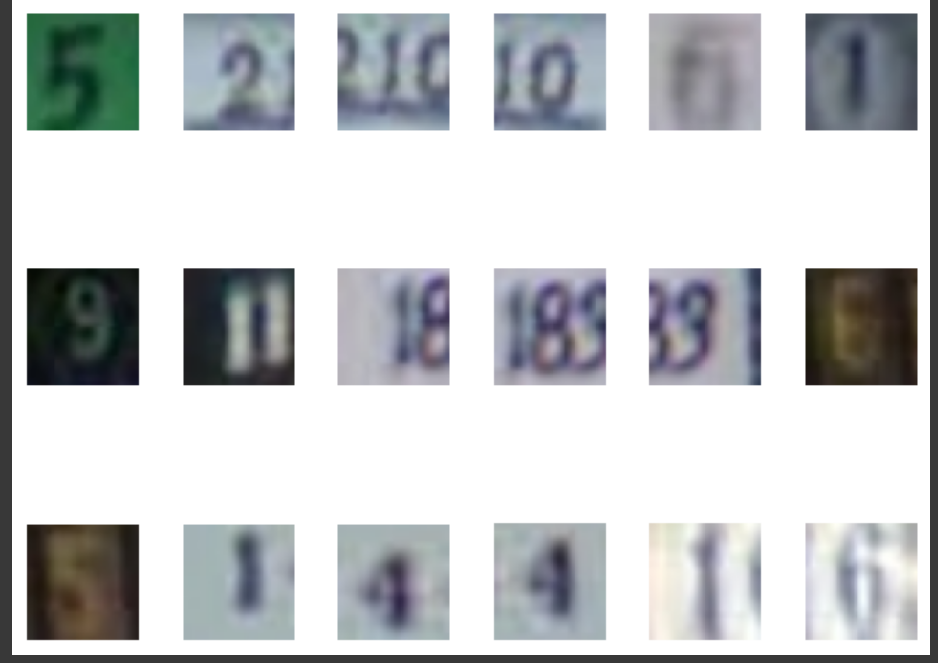

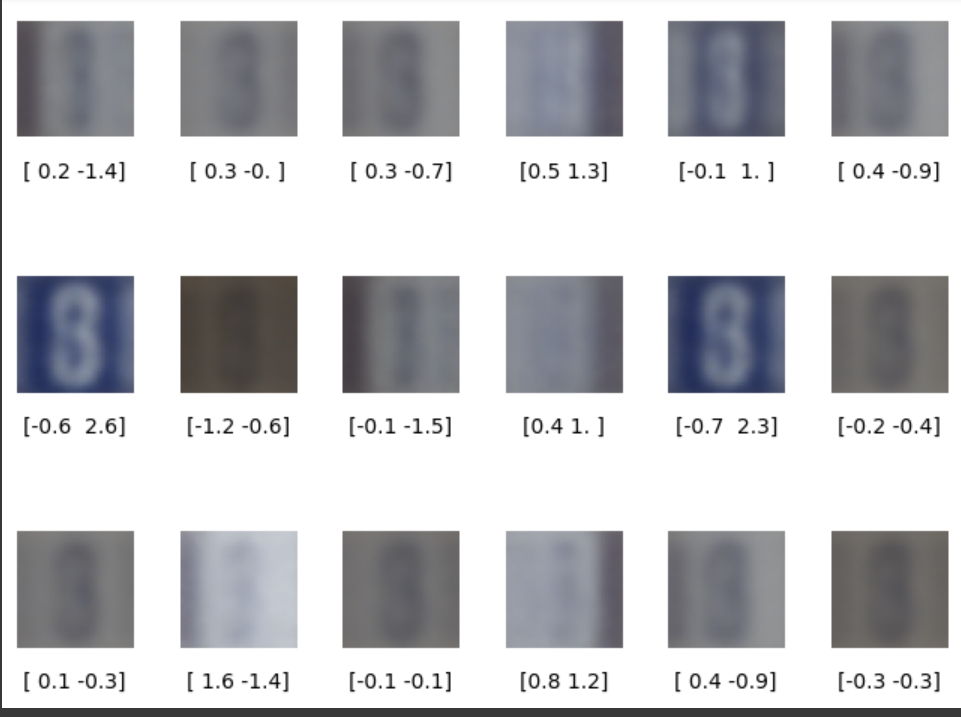

In [9]:
# Select a subset of the test set
n_to_predict = 5000
example_images = x_test[:n_to_predict]
example_labels = y_test[:n_to_predict]

In [ ]:
# Create autoencoder predictions and display
z_mean, z_log_var, reconstructions = vae.predict(example_images)
print("Example real clothing items")
display(example_images)
print("Reconstructions")
display(reconstructions)

157/157 [==============================] - 1s 8ms/step
Example real clothing items


array([[[[0.14901961, 0.40392157, 0.23529412],
         [0.15294118, 0.40784314, 0.23921569],
         [0.15294118, 0.40784314, 0.24313726],
         ...,
         [0.16078432, 0.4       , 0.23921569],
         [0.16470589, 0.40392157, 0.24313726],
         [0.15294118, 0.38039216, 0.22352941]],

        [[0.15294118, 0.40784314, 0.23921569],
         [0.15294118, 0.40784314, 0.23921569],
         [0.15294118, 0.40784314, 0.24313726],
         ...,
         [0.16078432, 0.4       , 0.23921569],
         [0.16862746, 0.39607844, 0.24705882],
         [0.15294118, 0.38039216, 0.22352941]],

        [[0.14901961, 0.4117647 , 0.24313726],
         [0.14509805, 0.40784314, 0.23921569],
         [0.15294118, 0.41568628, 0.24705882],
         ...,
         [0.16862746, 0.39607844, 0.24705882],
         [0.16862746, 0.39215687, 0.2509804 ],
         [0.15294118, 0.38039216, 0.23137255]],

        ...,

        [[0.20392157, 0.46666667, 0.30588236],
         [0.20784314, 0.47058824, 0.30980393]

Reconstructions


array([[[[0.27918637, 0.25438094, 0.23023166],
         [0.28233984, 0.25325105, 0.22693765],
         [0.27895695, 0.24909328, 0.22811732],
         ...,
         [0.27333757, 0.25009257, 0.22732562],
         [0.27654308, 0.25204712, 0.22753052],
         [0.27798042, 0.2536992 , 0.2291116 ]],

        [[0.2786791 , 0.25401524, 0.23220314],
         [0.2814091 , 0.25459015, 0.227518  ],
         [0.28242478, 0.25513595, 0.22915992],
         ...,
         [0.2744469 , 0.25187346, 0.22625381],
         [0.27998218, 0.2563782 , 0.22717409],
         [0.27914748, 0.2542432 , 0.22937456]],

        [[0.27713445, 0.24978621, 0.22388682],
         [0.27822536, 0.25562173, 0.22872493],
         [0.28059745, 0.2546576 , 0.2286514 ],
         ...,
         [0.2732989 , 0.24911496, 0.22455545],
         [0.281236  , 0.25432545, 0.22531459],
         [0.2782256 , 0.25455317, 0.23113063]],

        ...,

        [[0.27337018, 0.25045928, 0.23214144],
         [0.27240816, 0.25141996, 0.23014286]

In [ ]:
# Encode the example images
z_mean, z_var, z = encoder.predict(example_images)

157/157 [==============================] - 0s 3ms/step


In [ ]:
# Some examples of the embeddings
print(z[:10])

[[-1.3253509  -0.2363941 ]
 [ 1.0587169   0.71603096]
 [ 0.804593   -0.6087291 ]
 [ 0.8836241  -1.0390887 ]
 [ 1.0545764   0.22313714]
 [ 0.06858101  0.59987116]
 [-3.0264838  -1.0999432 ]
 [-1.0016603  -2.0252557 ]
 [ 1.2342619   0.84145164]
 [ 0.75989884  0.25187412]]


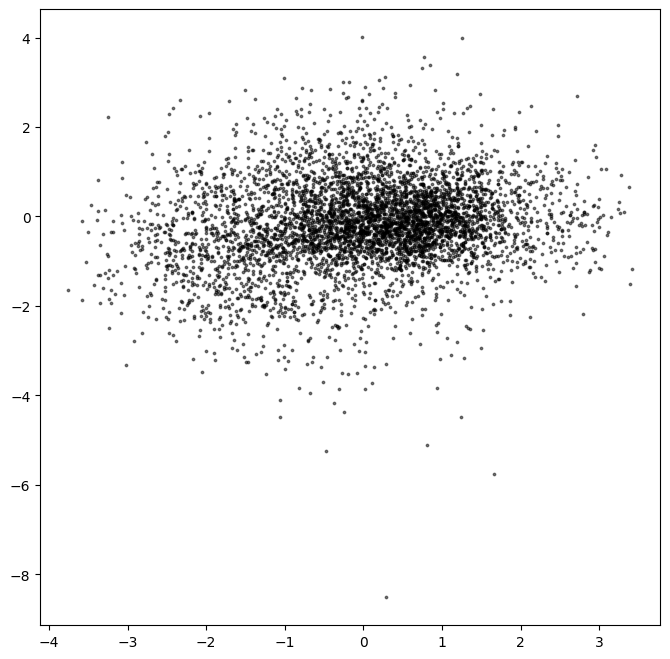

In [ ]:
# Show the encoded points in 2D space
figsize = 8

plt.figure(figsize=(figsize, figsize))
plt.scatter(z[:, 0], z[:, 1], c="black", alpha=0.5, s=3)
plt.show()

In [ ]:
# Sample some points in the latent space, from the standard normal distribution
grid_width, grid_height = (6, 3)
z_sample = np.random.normal(size=(grid_width * grid_height, 2))

In [ ]:
# Decode the sampled points
reconstructions = decoder.predict(z_sample)

1/1 [==============================] - 0s 29ms/step


In [ ]:
# Convert original embeddings and sampled embeddings to p-values
p = norm.cdf(z)
p_sample = norm.cdf(z_sample)

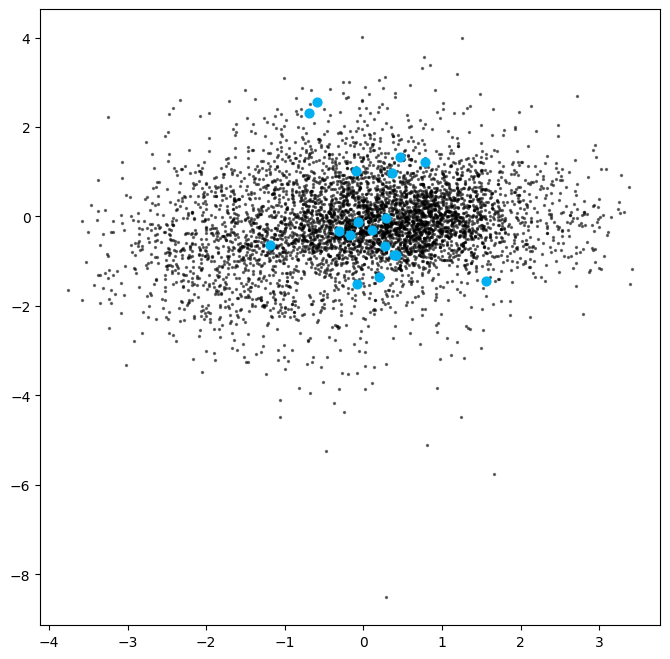

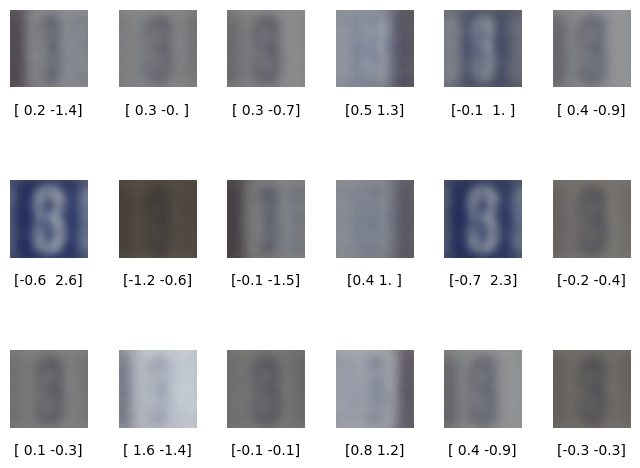

In [ ]:
# Draw a plot of...
figsize = 8
plt.figure(figsize=(figsize, figsize))

# ... the original embeddings ...
plt.scatter(z[:, 0], z[:, 1], c="black", alpha=0.5, s=2)

# ... and the newly generated points in the latent space
plt.scatter(z_sample[:, 0], z_sample[:, 1], c="#00B0F0", alpha=1, s=40)
plt.show()

# Add underneath a grid of the decoded images
fig = plt.figure(figsize=(figsize, grid_height * 2))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.text(
        0.5,
        -0.35,
        str(np.round(z_sample[i, :], 1)),
        fontsize=10,
        ha="center",
        transform=ax.transAxes,
    )
    ax.imshow(reconstructions[i, :, :], cmap="Greys")

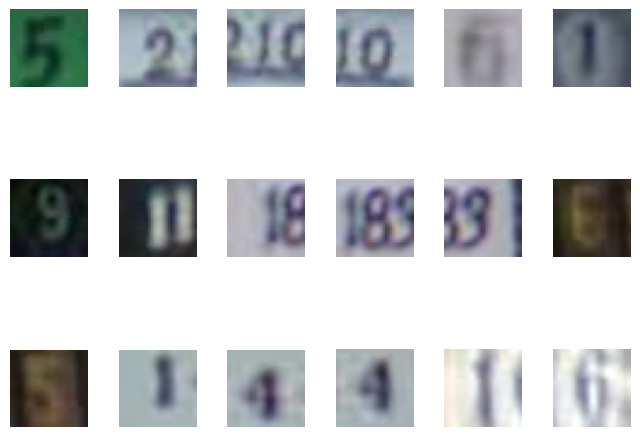

In [19]:
#Prints set of original images
figsize = 8
grid_height = 3
grid_width = 6
fig = plt.figure(figsize=(figsize, grid_height * 2))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(18):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")


    fontsize=10,
    ha="center",
    transform=ax.transAxes
    ax.imshow(example_images[i, :, :], cmap="Greys")

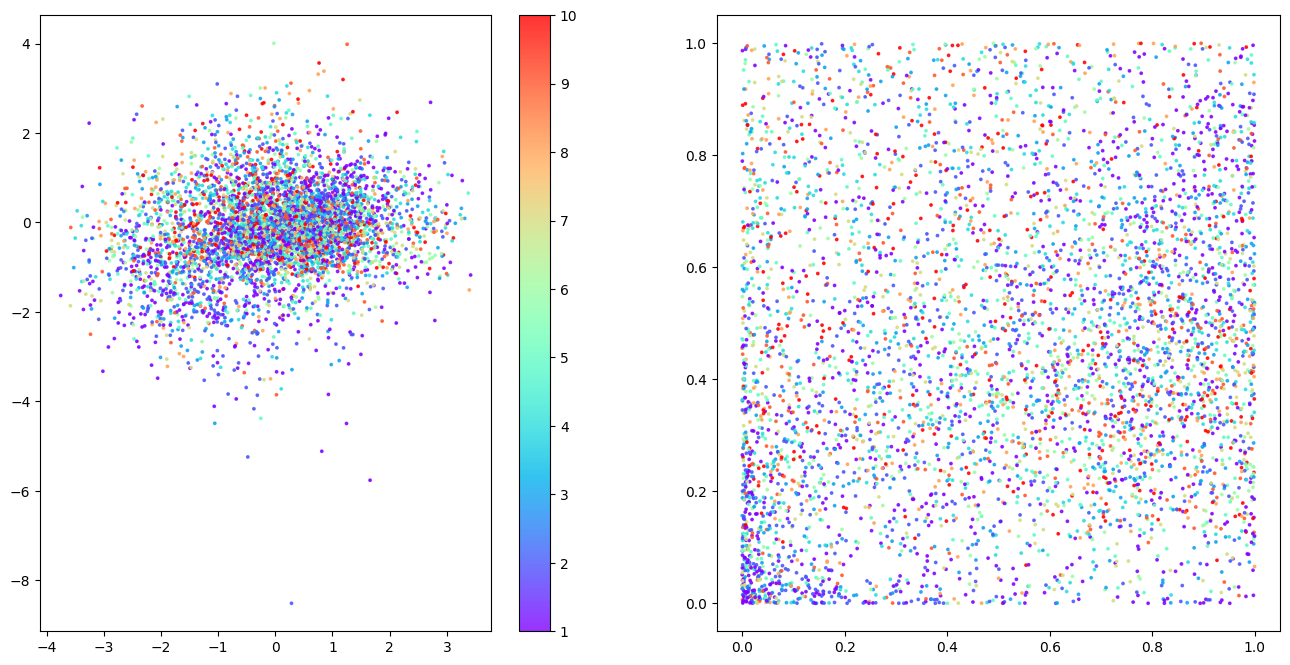

In [ ]:
# Colour the embeddings by their label
figsize = 8
fig = plt.figure(figsize=(figsize * 2, figsize))
ax = fig.add_subplot(1, 2, 1)
plot_1 = ax.scatter(
    z[:, 0], z[:, 1], cmap="rainbow", c=example_labels, alpha=0.8, s=3
)
plt.colorbar(plot_1)
ax = fig.add_subplot(1, 2, 2)
plot_2 = ax.scatter(
    p[:, 0], p[:, 1], cmap="rainbow", c=example_labels, alpha=0.8, s=3
)
plt.show()

8/8 [==============================] - 0s 6ms/step


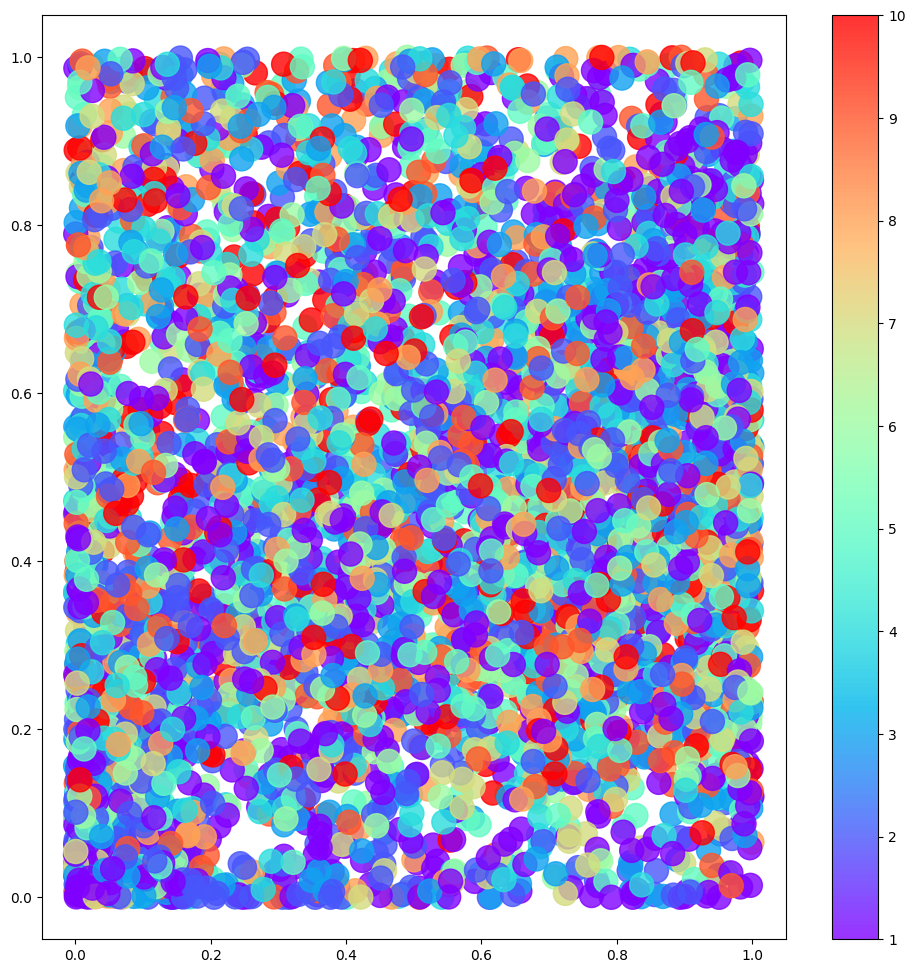

/usr/local/lib/python3.10/dist-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


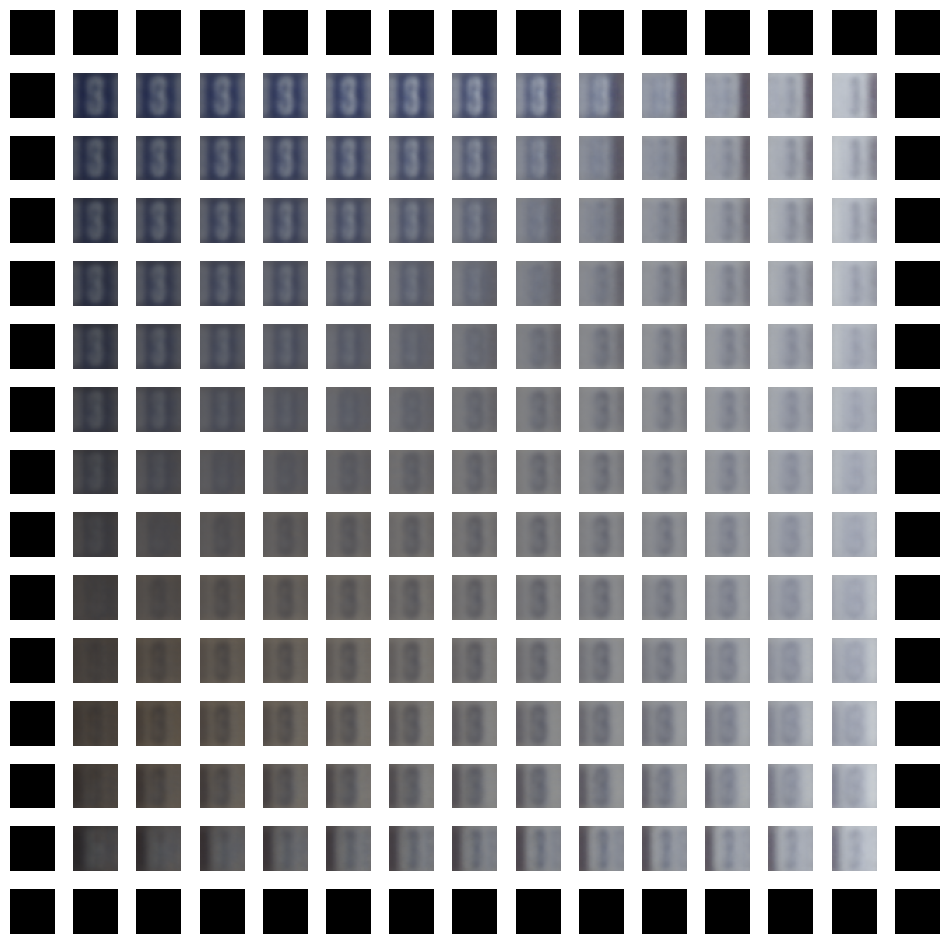

In [ ]:
# Colour the embeddings by their label
figsize = 12
grid_size = 15
plt.figure(figsize=(figsize, figsize))
plt.scatter(
    p[:, 0], p[:, 1], cmap="rainbow", c=example_labels, alpha=0.8, s=300
)
plt.colorbar()

x = norm.ppf(np.linspace(0, 1, grid_size))
y = norm.ppf(np.linspace(1, 0, grid_size))
xv, yv = np.meshgrid(x, y)
xv = xv.flatten()
yv = yv.flatten()
grid = np.array(list(zip(xv, yv)))

reconstructions = decoder.predict(grid)
# plt.scatter(grid[:, 0], grid[:, 1], c="black", alpha=1, s=10)
plt.show()

fig = plt.figure(figsize=(figsize, figsize))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(grid_size**2):
    ax = fig.add_subplot(grid_size, grid_size, i + 1)
    ax.axis("off")
    ax.imshow(reconstructions[i, :, :], cmap="Greys")

I also tried to improve the model by training it again with 50 epochs and batch size of 32. This model followed a similar trend of latent spaces not changing the loss that much. Compared to the last VAE, the total loss was about the same at 320.6429 for latent dimenstion of 10 but the validation loss was noticeably better with a latent dimension of 2 having a validation loss of 299.83005, compared to the last model's best validation loss of 315.42743. After training the model I displayed the same graphs as I did before and put a set of original images on top and a set of reconstructed images on the bottom.

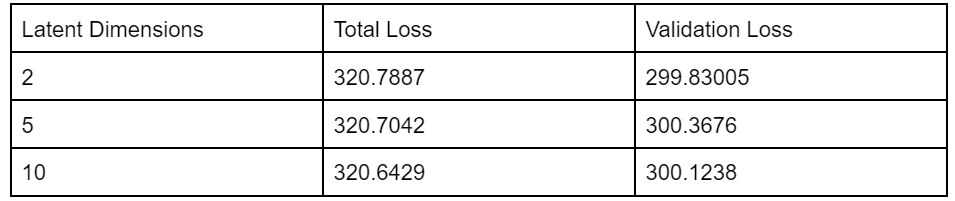

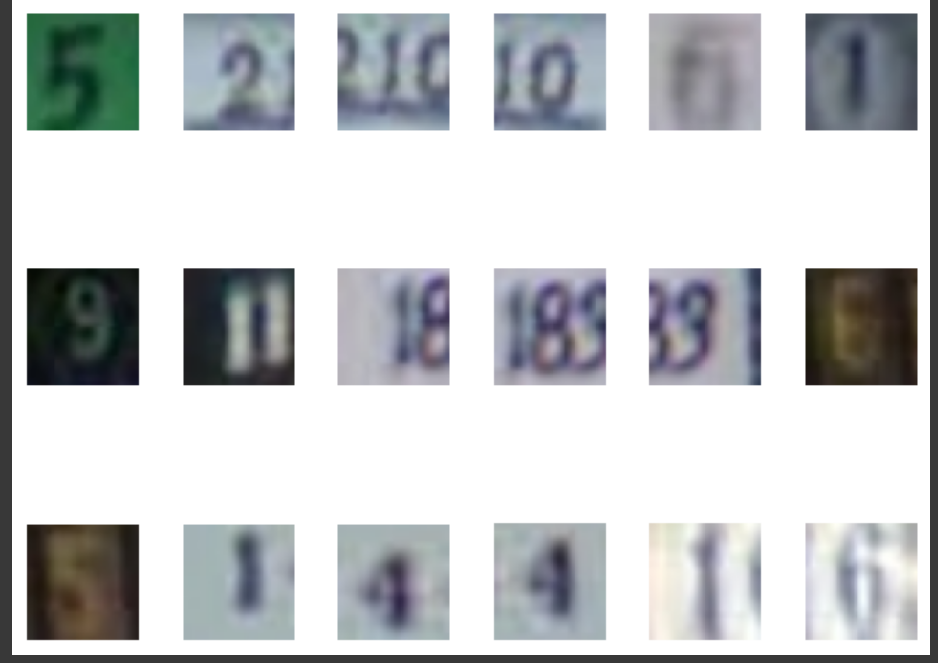

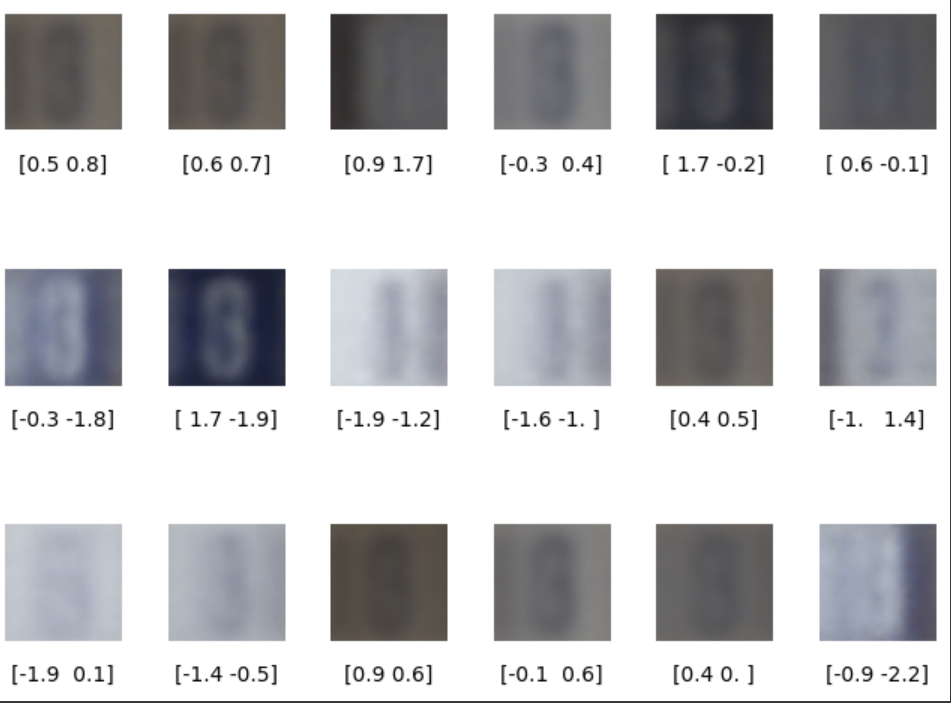

In [27]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint_callback = ModelCheckpoint(
    'vae_model2.tf',  # Path where the model will be saved
    save_best_only=True,  # Save only the best model
    monitor='val_loss',  # Monitor validation loss
    mode='min',  # We want the minimum loss
    verbose=1  # Print messages when saving
)

early_stopping_callback = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=10,  # Stop training after 10 epochs with no improvement
    verbose=1  # Print messages when stopping
)

In [28]:
latent_dims = [2, 5, 10]
for dim in latent_dims:
    print(f'Training VAE with latent dimension: {dim}')
    vae = build_vae(latent_dim=dim)
    vae.compile(optimizer='adam', loss=losses.binary_crossentropy)
    vae.fit(x_train, epochs=50, batch_size=32, validation_data=(x_test, x_test), callbacks=[checkpoint_callback, early_stopping_callback])

Training VAE with latent dimension: 2
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d_3 (Conv2D)           (None, 16, 16, 32)           896       ['encoder_input[0][0]']       
                                                                                                  
 conv2d_4 (Conv2D)           (None, 8, 8, 64)             18496     ['conv2d_3[0][0]']            
                                                                                                  
 conv2d_5 (Conv2D)           (None, 4, 4, 128)            73856     ['conv2d_4[0][0]']            
                                                      

2290/2290 [==============================] - 59s 25ms/step - total_loss: 324.3307 - reconstruction_loss: 321.9013 - kl_loss: 2.4283 - val_loss: 301.1923 - val_reconstruction_loss: 297.9743 - val_kl_loss: 3.2180
Epoch 2/50
2290/2290 [==============================] - ETA: 0s - total_loss: 321.2753 - reconstruction_loss: 318.5082 - kl_loss: 2.7667
Epoch 2: val_loss improved from 301.19226 to 300.52859, saving model to vae_model2.tf


2290/2290 [==============================] - 56s 25ms/step - total_loss: 321.2753 - reconstruction_loss: 318.5082 - kl_loss: 2.7667 - val_loss: 300.5286 - val_reconstruction_loss: 297.0415 - val_kl_loss: 3.4871
Epoch 3/50
2290/2290 [==============================] - ETA: 0s - total_loss: 321.1143 - reconstruction_loss: 318.3087 - kl_loss: 2.8049
Epoch 3: val_loss did not improve from 300.52859
2290/2290 [==============================] - 55s 24ms/step - total_loss: 321.1143 - reconstruction_loss: 318.3087 - kl_loss: 2.8049 - val_loss: 300.7240 - val_reconstruction_loss: 297.1277 - val_kl_loss: 3.5963
Epoch 4/50
2289/2290 [============================>.] - ETA: 0s - total_loss: 321.0455 - reconstruction_loss: 318.2252 - kl_loss: 2.8208
Epoch 4: val_loss improved from 300.52859 to 300.38855, saving model to vae_model2.tf


2290/2290 [==============================] - 56s 24ms/step - total_loss: 321.0515 - reconstruction_loss: 318.2313 - kl_loss: 2.8207 - val_loss: 300.3885 - val_reconstruction_loss: 296.9136 - val_kl_loss: 3.4750
Epoch 5/50
2289/2290 [============================>.] - ETA: 0s - total_loss: 321.0146 - reconstruction_loss: 318.1886 - kl_loss: 2.8258
Epoch 5: val_loss improved from 300.38855 to 300.31192, saving model to vae_model2.tf


2290/2290 [==============================] - 56s 24ms/step - total_loss: 321.0156 - reconstruction_loss: 318.1895 - kl_loss: 2.8258 - val_loss: 300.3119 - val_reconstruction_loss: 296.9277 - val_kl_loss: 3.3842
Epoch 6/50
2288/2290 [============================>.] - ETA: 0s - total_loss: 320.9835 - reconstruction_loss: 318.1528 - kl_loss: 2.8308
Epoch 6: val_loss improved from 300.31192 to 300.25183, saving model to vae_model2.tf


2290/2290 [==============================] - 56s 24ms/step - total_loss: 320.9832 - reconstruction_loss: 318.1526 - kl_loss: 2.8307 - val_loss: 300.2518 - val_reconstruction_loss: 296.7249 - val_kl_loss: 3.5269
Epoch 7/50
2290/2290 [==============================] - ETA: 0s - total_loss: 320.9653 - reconstruction_loss: 318.1260 - kl_loss: 2.8399
Epoch 7: val_loss did not improve from 300.25183
2290/2290 [==============================] - 55s 24ms/step - total_loss: 320.9653 - reconstruction_loss: 318.1260 - kl_loss: 2.8399 - val_loss: 300.8320 - val_reconstruction_loss: 297.3735 - val_kl_loss: 3.4584
Epoch 8/50
2289/2290 [============================>.] - ETA: 0s - total_loss: 320.9349 - reconstruction_loss: 318.0956 - kl_loss: 2.8391
Epoch 8: val_loss did not improve from 300.25183
2290/2290 [==============================] - 55s 24ms/step - total_loss: 320.9318 - reconstruction_loss: 318.0926 - kl_loss: 2.8390 - val_loss: 301.4179 - val_reconstruction_loss: 297.8201 - val_kl_loss: 3.

2290/2290 [==============================] - 57s 25ms/step - total_loss: 320.9319 - reconstruction_loss: 318.0793 - kl_loss: 2.8526 - val_loss: 299.8300 - val_reconstruction_loss: 296.3624 - val_kl_loss: 3.4676
Epoch 10/50
2289/2290 [============================>.] - ETA: 0s - total_loss: 320.8900 - reconstruction_loss: 318.0419 - kl_loss: 2.8486
Epoch 10: val_loss did not improve from 299.83005
2290/2290 [==============================] - 54s 24ms/step - total_loss: 320.8909 - reconstruction_loss: 318.0425 - kl_loss: 2.8489 - val_loss: 300.8149 - val_reconstruction_loss: 297.0893 - val_kl_loss: 3.7256
Epoch 11/50
2290/2290 [==============================] - ETA: 0s - total_loss: 320.8818 - reconstruction_loss: 318.0234 - kl_loss: 2.8583
Epoch 11: val_loss did not improve from 299.83005
2290/2290 [==============================] - 54s 24ms/step - total_loss: 320.8818 - reconstruction_loss: 318.0234 - kl_loss: 2.8583 - val_loss: 300.4366 - val_reconstruction_loss: 296.8140 - val_kl_loss

In [29]:
# Select a subset of the test set
n_to_predict = 5000
example_images = x_test[:n_to_predict]
example_labels = y_test[:n_to_predict]

In [30]:
# Create autoencoder predictions and display
z_mean, z_log_var, reconstructions = vae.predict(example_images)
print("Example real clothing items")
display(example_images)
print("Reconstructions")
display(reconstructions)

157/157 [==============================] - 2s 8ms/step
Example real clothing items


array([[[[0.14901961, 0.40392157, 0.23529412],
         [0.15294118, 0.40784314, 0.23921569],
         [0.15294118, 0.40784314, 0.24313726],
         ...,
         [0.16078432, 0.4       , 0.23921569],
         [0.16470589, 0.40392157, 0.24313726],
         [0.15294118, 0.38039216, 0.22352941]],

        [[0.15294118, 0.40784314, 0.23921569],
         [0.15294118, 0.40784314, 0.23921569],
         [0.15294118, 0.40784314, 0.24313726],
         ...,
         [0.16078432, 0.4       , 0.23921569],
         [0.16862746, 0.39607844, 0.24705882],
         [0.15294118, 0.38039216, 0.22352941]],

        [[0.14901961, 0.4117647 , 0.24313726],
         [0.14509805, 0.40784314, 0.23921569],
         [0.15294118, 0.41568628, 0.24705882],
         ...,
         [0.16862746, 0.39607844, 0.24705882],
         [0.16862746, 0.39215687, 0.2509804 ],
         [0.15294118, 0.38039216, 0.23137255]],

        ...,

        [[0.20392157, 0.46666667, 0.30588236],
         [0.20784314, 0.47058824, 0.30980393]

Reconstructions


array([[[[0.26780322, 0.24932806, 0.22506732],
         [0.27056393, 0.24995217, 0.22199516],
         [0.2598843 , 0.24071614, 0.22027881],
         ...,
         [0.23094067, 0.21480101, 0.19762899],
         [0.2302091 , 0.21222624, 0.194748  ],
         [0.22802366, 0.2097925 , 0.1941499 ]],

        [[0.26647586, 0.25064564, 0.22029413],
         [0.27207035, 0.25126174, 0.21948537],
         [0.25844896, 0.23717713, 0.2149033 ],
         ...,
         [0.2296703 , 0.2118085 , 0.19312942],
         [0.2281131 , 0.20949192, 0.19293942],
         [0.22809142, 0.20976605, 0.19366293]],

        [[0.27274847, 0.26063046, 0.23228206],
         [0.26999664, 0.25404537, 0.2229663 ],
         [0.25772572, 0.23762383, 0.21793622],
         ...,
         [0.2330108 , 0.21217856, 0.19897236],
         [0.23205046, 0.21136796, 0.19448832],
         [0.22838283, 0.20735054, 0.19309454]],

        ...,

        [[0.27947873, 0.26255178, 0.2523239 ],
         [0.2750107 , 0.25781292, 0.24585457]

In [31]:
# Encode the example images
z_mean, z_var, z = encoder.predict(example_images)

157/157 [==============================] - 1s 3ms/step


In [32]:
# Some examples of the embeddings
print(z[:10])

[[ 1.4216305   0.81376565]
 [-0.92150563 -0.5682966 ]
 [-0.7289475   0.35598427]
 [-0.9380151   0.12660113]
 [-0.9381703  -0.35341632]
 [ 0.35590434 -0.26891714]
 [ 2.8386738   0.950426  ]
 [ 1.2648629   2.71316   ]
 [-0.9824548  -0.96282965]
 [-0.7498799  -0.1622679 ]]


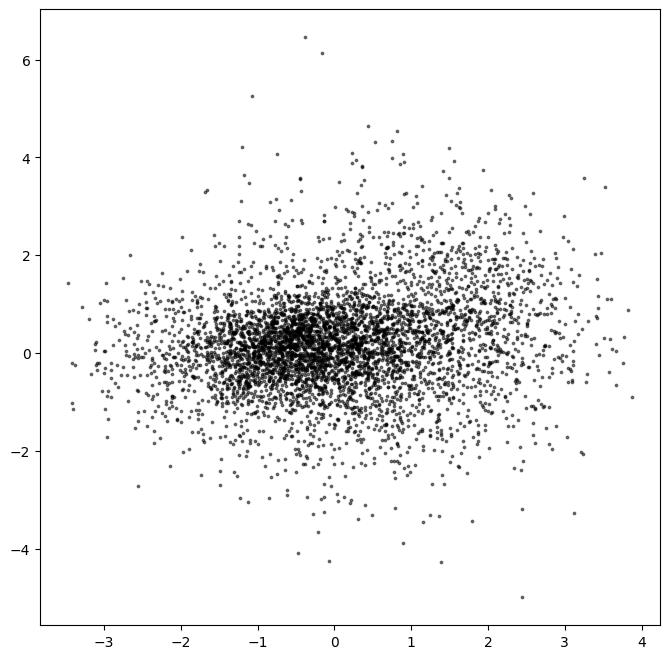

In [33]:
# Show the encoded points in 2D space
figsize = 8

plt.figure(figsize=(figsize, figsize))
plt.scatter(z[:, 0], z[:, 1], c="black", alpha=0.5, s=3)
plt.show()

In [34]:
# Sample some points in the latent space, from the standard normal distribution
grid_width, grid_height = (6, 3)
z_sample = np.random.normal(size=(grid_width * grid_height, 2))

In [35]:
# Decode the sampled points
reconstructions = decoder.predict(z_sample)

1/1 [==============================] - 0s 103ms/step


In [36]:
# Convert original embeddings and sampled embeddings to p-values
p = norm.cdf(z)
p_sample = norm.cdf(z_sample)

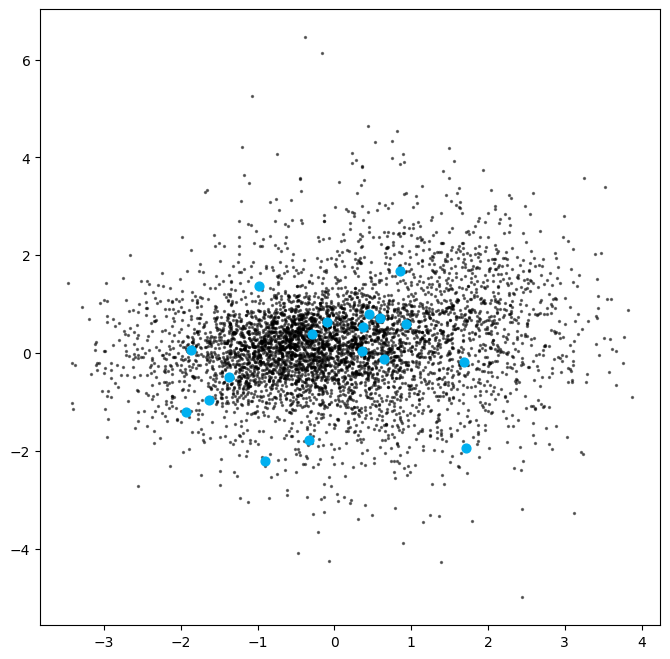

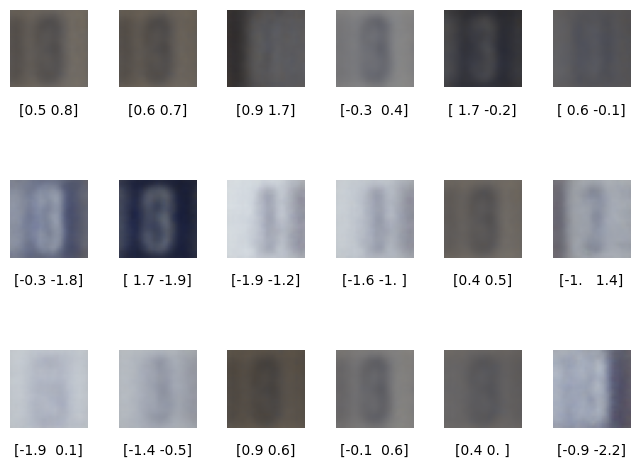

In [37]:
# Draw a plot of...
figsize = 8
plt.figure(figsize=(figsize, figsize))

# ... the original embeddings ...
plt.scatter(z[:, 0], z[:, 1], c="black", alpha=0.5, s=2)

# ... and the newly generated points in the latent space
plt.scatter(z_sample[:, 0], z_sample[:, 1], c="#00B0F0", alpha=1, s=40)
plt.show()

# Add underneath a grid of the decoded images
fig = plt.figure(figsize=(figsize, grid_height * 2))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.text(
        0.5,
        -0.35,
        str(np.round(z_sample[i, :], 1)),
        fontsize=10,
        ha="center",
        transform=ax.transAxes,
    )
    ax.imshow(reconstructions[i, :, :], cmap="Greys")

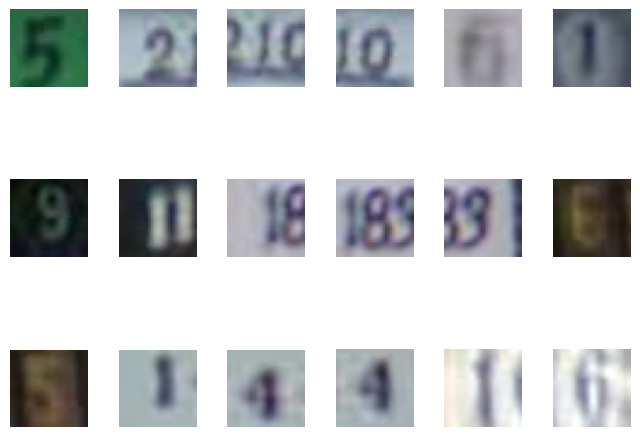

In [38]:
figsize = 8
grid_height = 3
grid_width = 6
fig = plt.figure(figsize=(figsize, grid_height * 2))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(18):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")


    fontsize=10,
    ha="center",
    transform=ax.transAxes
    ax.imshow(example_images[i, :, :], cmap="Greys")

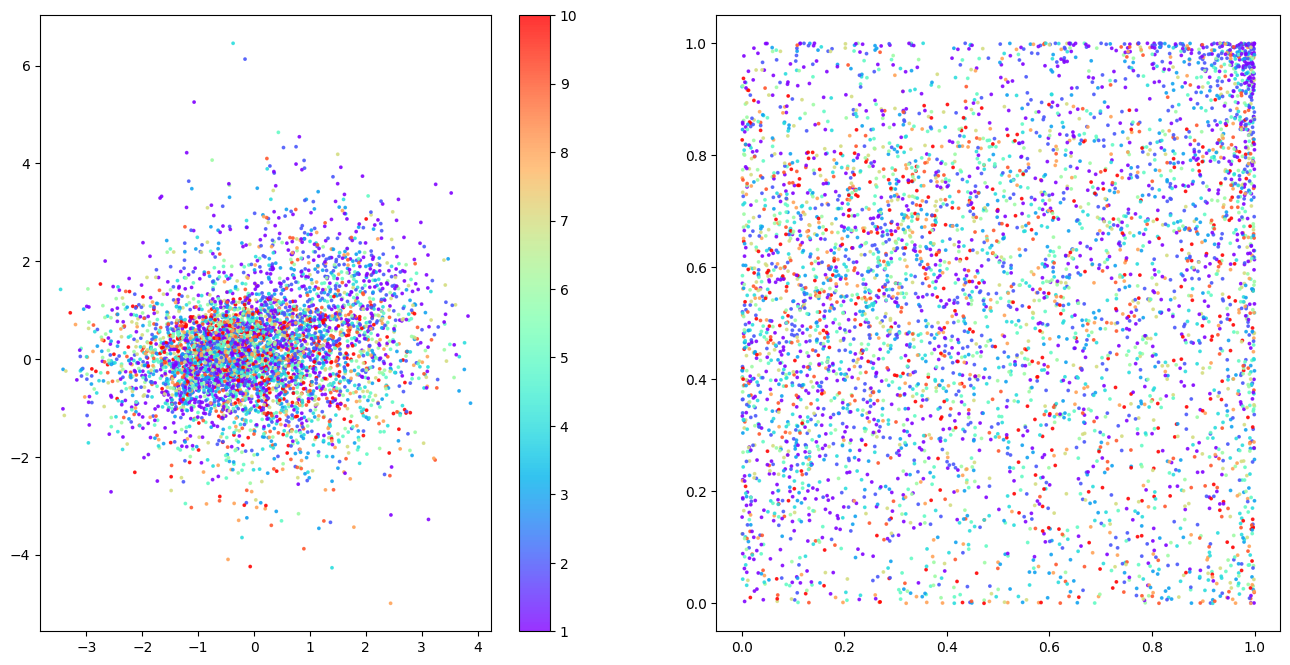

In [39]:
# Colour the embeddings by their label (clothing type - see table)
figsize = 8
fig = plt.figure(figsize=(figsize * 2, figsize))
ax = fig.add_subplot(1, 2, 1)
plot_1 = ax.scatter(
    z[:, 0], z[:, 1], cmap="rainbow", c=example_labels, alpha=0.8, s=3
)
plt.colorbar(plot_1)
ax = fig.add_subplot(1, 2, 2)
plot_2 = ax.scatter(
    p[:, 0], p[:, 1], cmap="rainbow", c=example_labels, alpha=0.8, s=3
)
plt.show()

8/8 [==============================] - 0s 6ms/step


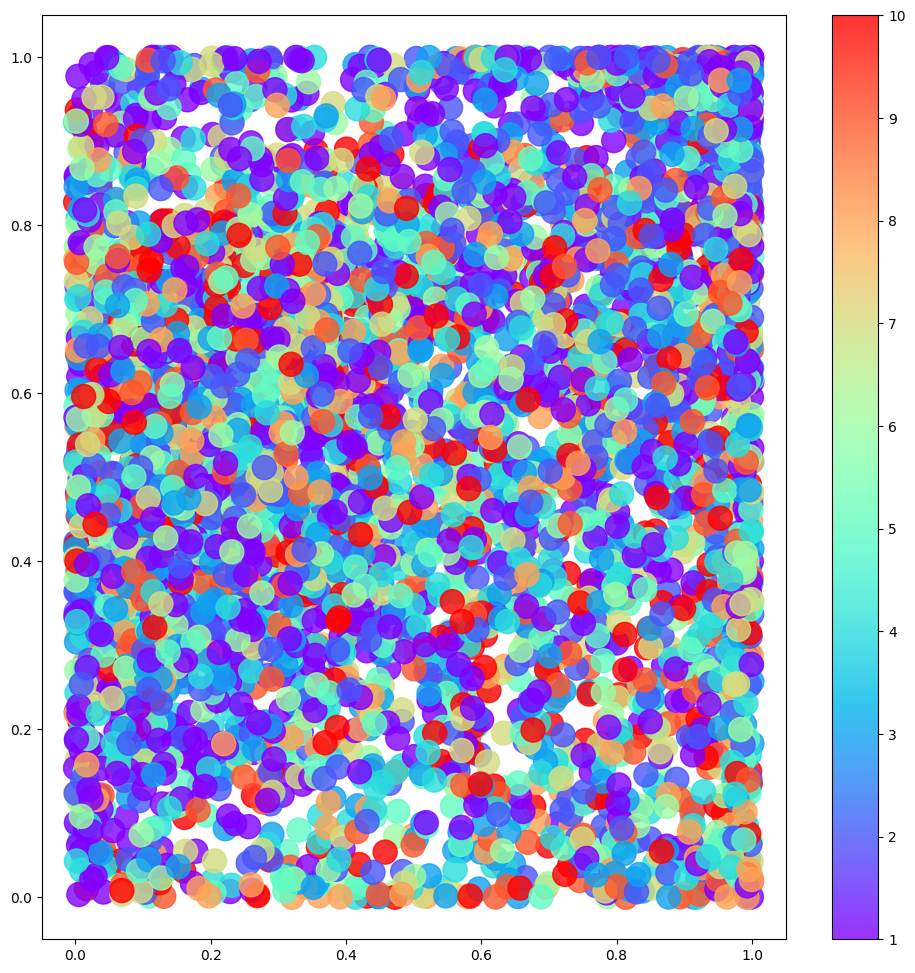

/usr/local/lib/python3.10/dist-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


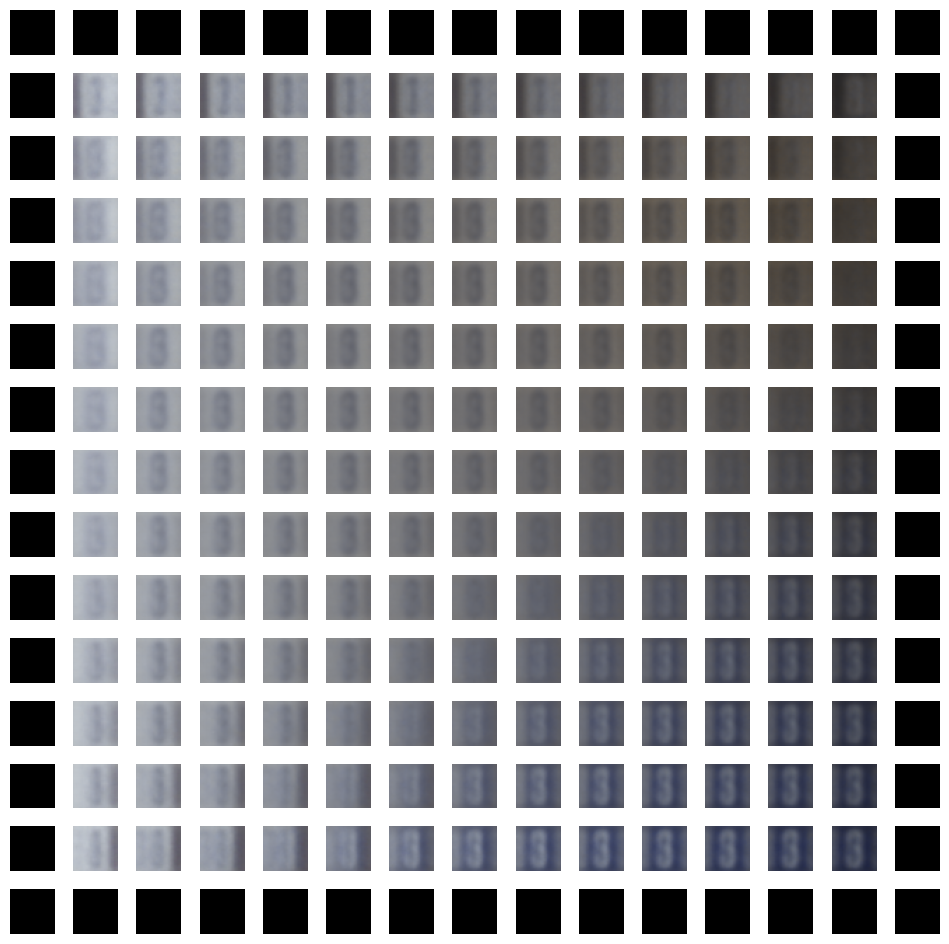

In [40]:
# Colour the embeddings by their label (clothing type - see table)
figsize = 12
grid_size = 15
plt.figure(figsize=(figsize, figsize))
plt.scatter(
    p[:, 0], p[:, 1], cmap="rainbow", c=example_labels, alpha=0.8, s=300
)
plt.colorbar()

x = norm.ppf(np.linspace(0, 1, grid_size))
y = norm.ppf(np.linspace(1, 0, grid_size))
xv, yv = np.meshgrid(x, y)
xv = xv.flatten()
yv = yv.flatten()
grid = np.array(list(zip(xv, yv)))

reconstructions = decoder.predict(grid)
# plt.scatter(grid[:, 0], grid[:, 1], c="black", alpha=1, s=10)
plt.show()

fig = plt.figure(figsize=(figsize, figsize))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(grid_size**2):
    ax = fig.add_subplot(grid_size, grid_size, i + 1)
    ax.axis("off")
    ax.imshow(reconstructions[i, :, :], cmap="Greys")

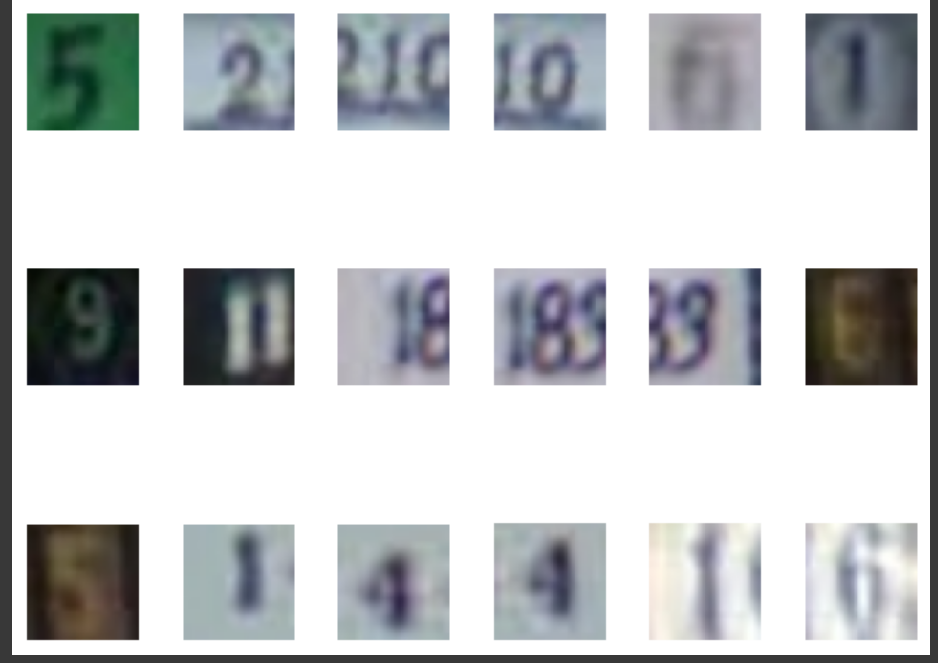

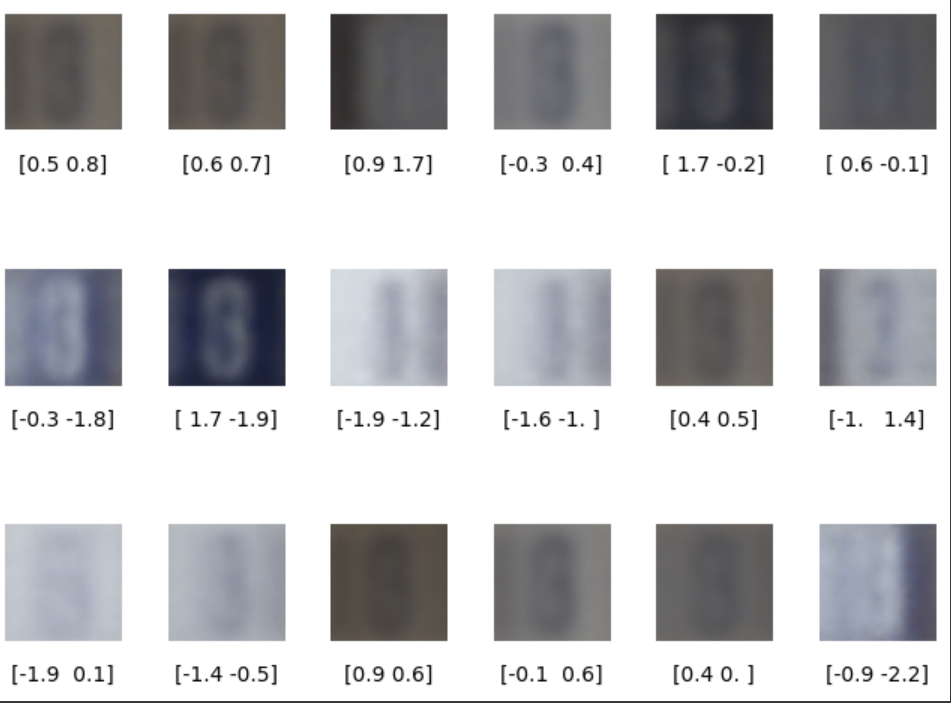

Discussion: I compared the original images on top with the reconstructed images on the bottom. Looking at the clarity of reconstructed images, while the image quality isn't the best and many of the pictures look blurry or dark, in some of them there are some decent recreations of numbers. There aren't as good as the originals but there are some reconstructed ones where a number can be made out pretty easily. Looking at distorations I'd say that in some of them, they aren't distored too badly. The details are kept mostly in tact and it is clear what they are. In some of the other images, they seem pretty distorted, with their not being much detail at all and it being very hard to tell what the image is. Looking at variability, it looks as though the model did similarly for different backgrounds and shade, with it maybe fairing slightly better with darker backgrounds. However, the reconstructed images didn't seem to capture mutiple numbers the best. Finally, the VAE doesn't seem to have generalized too well. Most of the images tend to resemble 1, 3, or 8. This indicates that these numbers are what the model has learned, while not learning the other numbers as well. Overall, the reconstructed images aren't terrible but leave much room for improvement. There are some decent images that resemble the originals but many don't do a great job and the variety of numbers that are represented is small.